#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [8]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

#%matplotlib inline #uncomment this line if you're running this notebook on your local PC

In [9]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



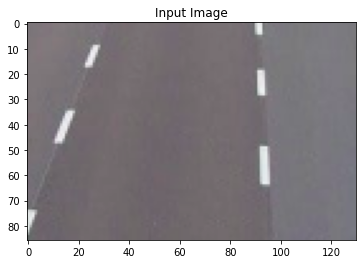


Starting point coordinates for the line 1 : 0 83
Ending point coordinates for the line 1 : 25 9

Starting point coordinates for the line 2 : 92 0
Ending point coordinates for the line 2 : 95 64

Starting point coordinates for the line 3 : 1 81
Ending point coordinates for the line 3 : 27 9

Starting point coordinates for the line 4 : 90 0
Ending point coordinates for the line 4 : 92 63



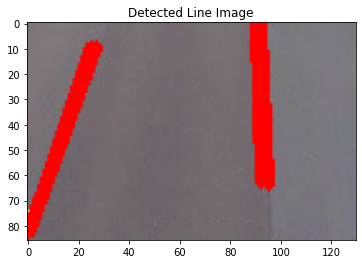

In [10]:
#Read image 
img = cv2.imread('/line.png', cv2.IMREAD_COLOR)


# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()


#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

#### YOUR CODE STARTS HERE #####

lines = cv2.HoughLinesP(edges,1,np.pi/180,15,minLineLength=60,maxLineGap=250)
lineCount = 1
for line in lines:
  x1,y1,x2,y2 = line[0]
  cv2.line(img,(x1,y1),(x2,y2),(255,0,0),3)
  print()
  print("Starting point coordinates for the line",lineCount,":",x1,y1)
  print("Ending point coordinates for the line",lineCount,":",x2,y2)
  lineCount += 1

print()
#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [11]:
import numpy as np
np.random.seed(0)



# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(np.round(num_points * out_rate))
        inliers = int(num_points - outliers)
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = np.dot(A, points_s[:, :inliers]) + t
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ####
        
        points_num = points_s.shape[1]

        affine_matrix = np.zeros((2 * points_num, 6))

        
        for i in range(points_num):
            temp1 = [[points_s[0, i], points_s[1, i], 0, 0, 1, 0],
                    [0, 0, points_s[0, i], points_s[1, i], 0, 1]]
            affine_matrix[2 * i: 2 * i + 2, :] = np.array(temp1,dtype="object")

        b1 = points_t.T.reshape((2 * points_num, 1))
        theta = np.linalg.lstsq(affine_matrix, b1,rcond=None)[0]

        A = theta[:4].reshape((2, 2))
        t = theta[4:]
        return A, t

        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)

# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE

        points_e = np.dot(A, points_s) + t
        diff_square = np.power(points_e - points_t, 2)
        residual = np.sqrt(np.sum(diff_square, axis=0))

        return residual

        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimateda ffine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE

        af = Transform()
        inliers_num = 0

        A = None
        t = None
        inliers = None

        for i in range(ITER_NUM):
            idx = np.random.randint(0, points_s.shape[1], (self.L, 1))
            A_tmp, t_tmp = af.affine_transformation(points_s[:, idx], points_t[:, idx])
            residual = self.calculate_distance(A_tmp, t_tmp, points_s, points_t)

            inliers_tmp = np.where(residual < self.thr)
            inliers_num_tmp = len(inliers_tmp[0])

            if inliers_num_tmp > inliers_num:
              inliers_num = inliers_num_tmp
              inliers = inliers_tmp
              A = A_tmp
              t = t_tmp

        return A, t, inliers
        
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print(inliers[0].shape)


(101,)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



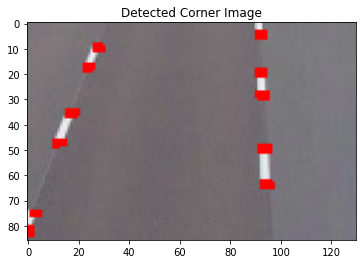

Total number of corners 222


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('/line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
# plt.imshow(image_copy, cmap='gray')
# plt.show()

## STEP 2: Detect corners
image_copy = np.float32(image_copy)
corners = cv2.cornerHarris(image_copy,2,3,0.04)
# num_corners = np.sum(corners > 0.1 * corners.max())

## STEP 3: Dilate corner image to enhance corner points
corners = cv2.dilate(corners,None)

## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
threshold = 0.1*corners.max()

## STEP 5: Count numer of detected corner points and draw them on the image
image[corners>threshold]=[255,0,0]
num_corners1 = np.sum(corners > threshold)
from google.colab.patches import cv2_imshow
plt.imshow(image)
plt.title('Detected Corner Image')
plt.show()
print("Total number of corners",num_corners1)



### YOUR CODE ENDS HERE

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [ ]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define a transforms for preparing the dataset
# convert the image to a pytorch tensor
# normalise the images with mean (0.1307) and std (0.3081) of the dataset

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
#### YOUR CODE ENDS HERE ####

In [ ]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)
test_dataset = datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transform)
#### YOUR CODE ENDS HERE ####

In [ ]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=32, 
                                           shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=32, 
                                          shuffle=False)
#### YOUR CODE ENDS HERE ####

### Network Definition

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)   # Input = 1x28x28  Output = 16x26x26
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1)  # Input = 16x26x26 Output = 32x24x24
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1)  # Input = 32x24x24 Output = 64x22x22
        # define a max pooling layer with kernel size 2
        self.maxPool1 = nn.MaxPool2d(2)                              # Output = 64x11x11
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
         
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.maxPool1(out)
        out = F.relu(out)
        
        out = out.view(-1,64*11*11)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [ ]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.016s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target = data.to(device), target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output, target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
            train_losses.append(loss.item())
            train_counter.append((batch_idx*32) + ((epoch-1)*len(train_loader.dataset)))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data, target = data.to(device), target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

In [ ]:
epochs = 25
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dataloader.dataset) for i in range(epochs)]

model = Net().to(device)
optimizer =  torch.optim.Adam(model.parameters(),lr=0.01)

start = timeit.default_timer()

for epoch in range(epochs):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)  

stop = timeit.default_timer()

print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301360
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.395732
Train Epoch: 0 [1280/60000 (2%)]	Loss: 1.154274
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.442890
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.550707
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.731598
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.529796
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.377155
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.292703
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.451958
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.452175
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.273398
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.501798
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.478429
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.246655
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.509746
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.412386
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.161859
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.253166
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.367142
Train Epoch: 0 [12800/60000 (

Text(0, 0.5, 'negative log likelihood loss')

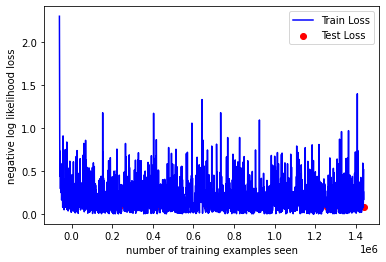

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

### Answer

Train: [59520/60000 (99%)]	Loss: 0.513734

Test set: Average loss: 0.0828, Accuracy: 9764/10000 (98%)

Total time taken: 453 seconds

### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

In [ ]:
class Net_Sigmoid_Func(nn.Module):
    def __init__(self):
        super(Net_Sigmoid_Func, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)   # Input = 1x28x28  Output = 16x26x26
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1)  # Input = 16x26x26 Output = 32x24x24
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1)  # Input = 32x24x24 Output = 64x22x22
        # define a max pooling layer with kernel size 2
        self.maxPool1 = nn.MaxPool2d(2)                              # Output = 64x11x11
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
         
        out = self.conv1(x)
        out = torch.sigmoid(out)
        out = self.conv2(out)
        out = torch.sigmoid(out)
        out = self.conv3(out)
        out = self.maxPool1(out)
        out = torch.sigmoid(out)
        
        out = out.view(-1,64*11*11)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = torch.sigmoid(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output


model_sig = Net_Sigmoid_Func().to(device)
optimizer_sig =  torch.optim.Adam(model_sig.parameters(),lr=0.01)

start = timeit.default_timer()

for epoch in range(25):
    train(model_sig, device, train_dataloader, optimizer_sig, epoch)
    test(model_sig, device, test_dataloader)  

stop = timeit.default_timer()

print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.369529
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.219300
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.407483
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.501661
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.480729
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.388412
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.374593
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.561162
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.350263
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.393695
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.261247
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.385564
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.338972
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.402170
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.531737
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.589296
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.390185
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.437557
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.336525
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.440327
Train Epoch: 0 [12800/60000 (

### Answer:

Yes, there is a significant drop in the accuracy rate.

The major reason for this is the high likelihood of the gradient to vanish. That is, the gradient of sigmoids becomes increasingly small as the absolute value of "x" increases. 

𝑆′(𝑎) = 𝑆(𝑎)(1−𝑆(𝑎))

When "𝑎" grows to infinite large

𝑆′(𝑎) = 𝑆(𝑎)(1−𝑆(𝑎)) = 1×(1−1) = 0 

Another reason being, sigmoid functions are likely to generate some non-zero value resulting in dense representations. Due to this, the sparsity gets lost.

Apart from the above mentioned reasons, ReLU is much more easier to compute than Sigmoid function due to the absence of exponential term in ReLU.






### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

In [ ]:
class Net_SGD(nn.Module):
    def __init__(self):
        super(Net_SGD, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)   # Input = 1x28x28  Output = 16x26x26
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1)  # Input = 16x26x26 Output = 32x24x24
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1)  # Input = 32x24x24 Output = 64x22x22
        # define a max pooling layer with kernel size 2
        self.maxPool1 = nn.MaxPool2d(2)                              # Output = 64x11x11
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
         
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.maxPool1(out)
        out = F.relu(out)
        
        out = out.view(-1,64*11*11)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output



model = Net_SGD().to(device)
optimizer =  torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

start = timeit.default_timer()

for epoch in range(25):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)  

stop = timeit.default_timer()

print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306213
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.834157
Train Epoch: 0 [1280/60000 (2%)]	Loss: 1.124299
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.900051
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.766270
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.709386
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.597258
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.762603
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.298719
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.336969
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.388024
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.385861
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.649538
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.515738
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.232486
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.115327
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.288648
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.173155
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.462483
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.145496
Train Epoch: 0 [12800/60000 (

### Answer

There is a slight rise in the Accuracy when we use the SGD model. One of the main reasons for this is:

1. The optimal learning rate for Adam is 0.001 and for SGD it is 0.01. But in case of Adam we are only using 0.01. That has a significant effect.

2. Adam generally optimizes poorly compared to that of SGD in certain settings.

### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

In [ ]:
class Net_Conv2d(nn.Module):
    def __init__(self):
        super(Net_Conv2d, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)   # Input = 1x28x28  Output = 16x26x26
        self.conv1.weight.data.fill_(1)
        self.conv1.bias.data.fill_(1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1)  # Input = 16x26x26 Output = 32x24x24
        self.conv2.weight.data.fill_(1)
        self.conv2.bias.data.fill_(1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1)  # Input = 32x24x24 Output = 64x22x22
        self.conv3.weight.data.fill_(1)
        self.conv3.bias.data.fill_(1)
        # define a max pooling layer with kernel size 2
        self.maxPool1 = nn.MaxPool2d(2)                              # Output = 64x11x11
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
         
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.maxPool1(out)
        out = F.relu(out)
        
        out = out.view(-1,64*11*11)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output



model = Net_Conv2d().to(device)
optimizer =  torch.optim.Adam(model.parameters(),lr=0.01)

start = timeit.default_timer()

for epoch in range(25):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)  

stop = timeit.default_timer()

print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 0 [0/60000 (0%)]	Loss: 138127.484375
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.012700
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.306375
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.233470
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.307069
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.220966
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.317341
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.305355
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.313388
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.291468
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.288319
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.236794
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.232802
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.292501
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.290812
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.279322
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.279010
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.233721
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.204326
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.287906
Train Epoch: 0 [12800/60

### Answer

This is a classic case of Weight Symmetry. Due to this, at the time of backpropagation, all the weights and bias values will be getting changed in symmetric basis. This means that all hidden units connected directly to the output units will get identical error signals, and, since the weight changes depend on the error signals, the weights from those units to the output units must always be the same. The system is starting out at a kind of unstable equilibrium point that keeps the weights equal, but it is higher than some neighboring points on the error surface, and once it moves away to one of these points, it will never return. 

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

In [ ]:
class Net_Xavier(nn.Module):
    def __init__(self):
        super(Net_Xavier, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)   # Input = 1x28x28  Output = 16x26x26
        torch.nn.init.xavier_normal_(self.conv1.weight)
        torch.nn.init.zeros_(self.conv1.bias)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1)  # Input = 16x26x26 Output = 32x24x24
        torch.nn.init.xavier_normal_(self.conv2.weight)
        torch.nn.init.zeros_(self.conv2.bias)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1)  # Input = 32x24x24 Output = 64x22x22
        torch.nn.init.xavier_normal_(self.conv3.weight)
        torch.nn.init.zeros_(self.conv3.bias)
        # define a max pooling layer with kernel size 2
        self.maxPool1 = nn.MaxPool2d(2)                              # Output = 64x11x11
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
         
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.maxPool1(out)
        out = F.relu(out)
        
        out = out.view(-1,64*11*11)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output


model = Net_Xavier().to(device)
optimizer =  torch.optim.Adam(model.parameters(),lr=0.01)


start = timeit.default_timer()

for epoch in range(25):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)  

stop = timeit.default_timer()

print('Total time taken: {} seconds'.format(int(stop - start)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290912
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.196397
Train Epoch: 0 [1280/60000 (2%)]	Loss: 1.447962
Train Epoch: 0 [1920/60000 (3%)]	Loss: 1.648077
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.941134
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.024281
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.681224
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.286246
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.943007
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.719126
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.640781
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.264527
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.381135
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.732208
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.334187
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.254753
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.132964
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.365437
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.485101
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.416408
Train Epoch: 0 [12800/60000 (

### Answer

The final test accuracy is 98%.

### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

In [ ]:
class Net_BN(nn.Module):
    def __init__(self):
        super(Net_BN, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)   # Input = 1x28x28  Output = 16x26x26
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1)  # Input = 16x26x26 Output = 32x24x24
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1)  # Input = 32x24x24 Output = 64x22x22
        # define a max pooling layer with kernel size 2
        self.maxPool1 = nn.MaxPool2d(2)                              # Output = 64x11x11
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
         
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = F.relu(out)
        out = self.maxPool1(out)
        
        
        out = torch.flatten(out, 1)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output


model = Net_BN().to(device)
optimizer =  torch.optim.Adam(model.parameters(),lr=0.001)

start = timeit.default_timer()

for epoch in range(25):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)  

stop = timeit.default_timer()

print('Total time taken: {} seconds'.format(int(stop - start)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.479180
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.881910
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.928933
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.448268
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.445464
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.295325
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.595810
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.217679
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.659293
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.360276
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.133587
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.736437
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.425407
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.534481
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.451619
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.297619
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.122120
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.237561
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.217191
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.254267
Train Epoch: 0 [12800/60000 (

### Answer

The final test accuracy is 99%.

Batch Normalization is a technique that mitigates the effect of unstable gradients within deep neural networks. BN introduces an additional layer to the neural network that performs operations on the inputs from the previous layer.
The operation standardizes and normalizes the input values. The input values are then transformed through scaling and shifting operations.

Batch normalization helps in making the weights in the hidden layer with standardized mean & variance. Normalization is typically carried out on the input data, but it would make sense that the flow of internal data within the network should remain normalized.

It helps in reducing the common problem of vanishing gradients, and covariance shift within neural network is reduced.



# Part-3 (Optional)

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
